In [1]:
import matplotlib.pyplot as plt
import numpy as np
import msgpack as mp
import msgpack_numpy as mpn
import os
import sys
import cv2
# directory reach

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
from support.ar_calculations import calculate_rotmat
from support.detect_lframe import detect_lframe_from_img
# from support.pymf import get_MF_devices as get_camera_list

In [2]:
# Enter folder name of calibration data

_folder_name = "calibration_00"
_parent_folder = "paper"

"""pth to calibration files"""
_pth = os.path.join(os.path.dirname(os.getcwd()), "recorded_data", _parent_folder,_folder_name)
_pth

'd:\\CMC\\DeepVision\\recorded_data\\paper\\calibration_00'

In [3]:
def calculate_rotmat_from_3markers(corners, ids, camera_matrix, dist_coeffs, marker_length = 0.05):

    rotation_vector, translation_vector, _ = cv2.aruco.estimatePoseSingleMarkers(corners, marker_length, camera_matrix, dist_coeffs)

    ids = list(ids)

    z_inx = ids.index(80)
    org_inx = ids.index(0)
    x_inx = ids.index(49)
    print(z_inx, org_inx, x_inx)

    zvec = translation_vector[z_inx][0]
    zvec = np.reshape(zvec, (3, 1))
    org = translation_vector[org_inx][0] 
    org = np.reshape(org, (3, 1))
    xvec = translation_vector[x_inx][0]
    xvec = np.reshape(xvec, (3, 1))


    translation_vector
    zvec
    rotMat = calculate_rotmat(xvec, zvec, org)
    rotMat

    t_zvec = zvec - org 
    t_xvec = xvec - org

    translation_correction = np.array([0.045, -0.05, 0.045]).reshape(3, 1) # adding the corrections in the new L frame

    rotMat.T@t_zvec + translation_correction
    # print(t_xvec)
    print(rotMat.T@t_xvec) 
    print(rotMat.T@t_zvec)


    return rotMat, org

In [4]:
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
cap.set(cv2.CAP_PROP_FPS, 30)


True

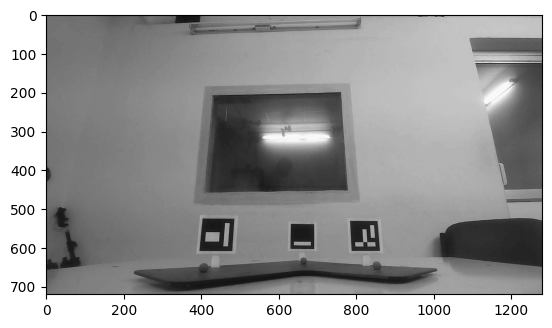

In [27]:

while True:
    ret, frame = cap.read()
    gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray_image = gray_image.copy()
    break

plt.imshow(gray_image, cmap='gray')

In [28]:
"""for webcam calculating rotmat"""
_webcam_calib_file = os.path.join(_pth, "webcam_calibration.msgpack")
corners, ids, _ = detect_lframe_from_img(gray_image)
with open(_webcam_calib_file, "rb") as f:
    webcam_calib = mp.load(f, object_hook=mpn.decode)
    w_camera_matrix = webcam_calib[0]
    w_dist_coeffs = webcam_calib[1]

w_rotmat, w_org = calculate_rotmat_from_3markers(corners, ids, marker_length=0.05, camera_matrix=w_camera_matrix, dist_coeffs=w_dist_coeffs)

2 0 1
[[0.14951079]
 [0.        ]
 [0.        ]]
[[-3.63794429e-03]
 [ 3.46944695e-18]
 [ 1.96723345e-01]]


In [29]:
"""save image in msgpack format"""

_webcam_frame_file = os.path.join(_pth, "armbo_orient_frame.msgpack")
with open(_webcam_frame_file, "wb") as f:
    _f = mp.packb(gray_image, default=mpn.encode)
    f.write(_f)

In [30]:
#save to path
_webcam_rotmat_file = os.path.join(_pth, "armbo_orient_rotmat.msgpack")
with open(_webcam_rotmat_file, "wb") as f:
    _rt_packed = mp.packb(w_rotmat, default=mpn.encode)
    _org_packed = mp.packb(w_org, default=mpn.encode)
    f.write(_rt_packed)
    f.write(_org_packed)
    f.close()

In [31]:
cap.release()